In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Working with PyTorch - Flowers DataSet

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from torchvision.transforms import v2
from torchvision import datasets

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'
altName = 'torch_all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE)

EPOCHS = 201 # number of epochs

BATCH_SIZE = 16

ALPHA = 0.001 # learning rate

TRAIN_SIZE = int(BATCH_SIZE*184) #
TEST_SIZE = 0.2 

# Input Image size
IMG_HEIGHT = 186
IMG_WIDTH = 186

# for early stopping 
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
TRAIN_SIZE

2944

## Basic Hygiene

In [5]:
torch.__version__

'2.3.0+cpu'

In [6]:
import torchvision
torchvision.__version__

'0.18.0+cpu'

In [7]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

In [8]:
def fn_showImages(img, ax):

    img = img.numpy().transpose((1,2,0))  #change to channel last

    means = np.array([0.485, 0.456, 0.406])  #mean as per transforms
    
    stds = np.array([0.229, 0.224, 0.225])   #std as per transform
    
    img = stds * img + means     #undo normalization
     
    img = np.clip(img, 0, 1)     #clip values between [0,1]
    
    ax.imshow(img)
    ax.axis('off')

In [9]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

Is CUDA available:  False
CUDA version:  None


In [10]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


## Read Flowers data set

In [11]:
###---------------
### Transformation
###---------------

train_transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    
    #augmentation transformations
    v2.RandomRotation(degrees=(-45, +45)),
    v2.CenterCrop(IMG_HEIGHT),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

test_transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.CenterCrop(IMG_HEIGHT),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  ])


'''
this is where we will add data augmentation
'''

data_dir = os.path.join(inpDir, subDir)

train_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(data_dir, transform=test_transform)

In [12]:
image, label = next(iter(train_dataset))
image.shape, label

(torch.Size([3, 186, 186]), 0)

In [13]:
dataset_size = len(train_dataset)

indices = torch.randperm(dataset_size).tolist()

train_dataset = torch.utils.data.Subset(train_dataset, indices[:TRAIN_SIZE])

test_dataset = torch.utils.data.Subset(test_dataset, indices[TRAIN_SIZE:])

len(train_dataset), len(test_dataset)


(2944, 726)

## Data Loader

In [14]:
#torch.utils.data.DataLoader?

In [15]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)


trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

184 45


In [16]:
class_names = {count: nClass for count, nClass in enumerate(train_dataset.dataset.classes)}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [17]:
numClasses = len(class_names)
numClasses

5

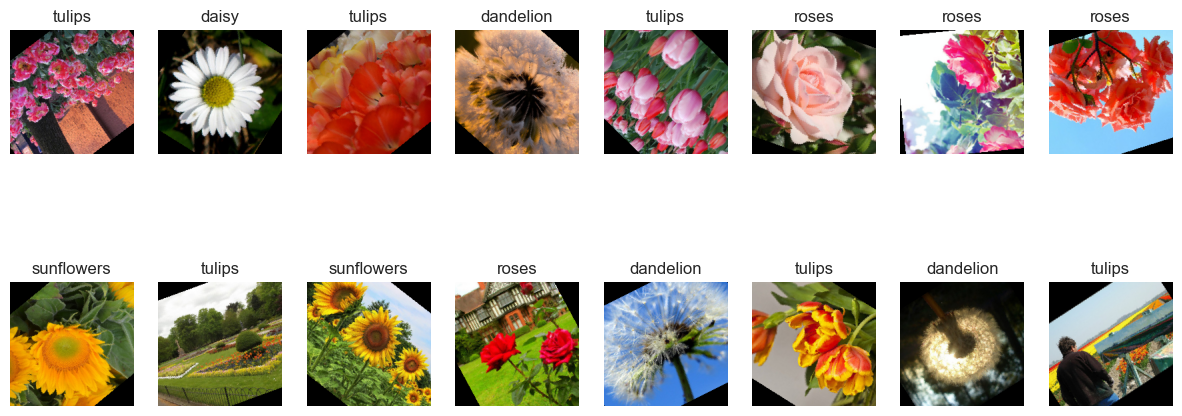

In [18]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure()

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])

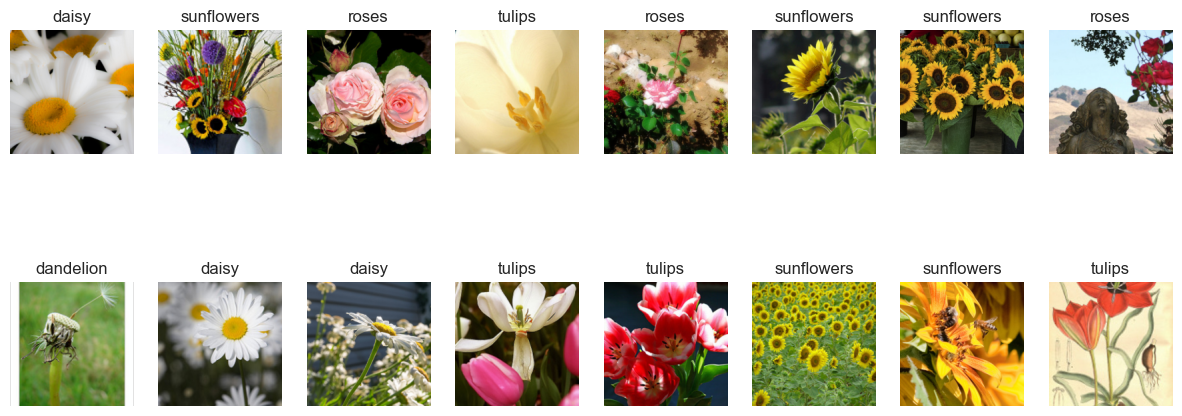

In [19]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure()

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])

In [20]:
class LeNet(nn.Module):

    def __init__(self, numChannels, classes) :

        #call parent constructor
        super(LeNet, self).__init__()

        #dropouts
        dor1 = 0.3
        dor2 = 0.3
        dor3 = 0.4
        dor4 = 0.5
        dor5 = 0.5

        #Define Layers
        
        # Set 1
        out_channels1 = 32
        # conv --> BN --> LeakyRelu --> Pool --> DO
        self.conv1 = nn.Conv2d(in_channels = numChannels,
                              out_channels = out_channels1,
                              kernel_size = (3,3)) #output_shape 184, 184, 128
        
        self.bn1 = nn.BatchNorm2d(out_channels1)
        self.actv1 = nn.LeakyReLU()      
        self.maxpool1 = nn.MaxPool2d(kernel_size=(4,4),
                                    stride=(4,4))  #output_shape 46 X 46 X 128     
        self.dropout1 = nn.Dropout(p=dor1)
        

        #---------------------------------------------------------------------------------------

        # Set 2
        out_channels2 = 128
        # conv --> BN --> LeakyRelu --> Pool --> DO
        self.conv2 = nn.Conv2d(in_channels = out_channels1,
                              out_channels = out_channels2,
                              kernel_size = (3,3)) #output_shape 44, 44, 128
        self.bn2 = nn.BatchNorm2d(out_channels2)
        self.actv2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2),
                                    stride=(2,2))  #output_shape 22 X 22 X 128
        self.dropout2 = nn.Dropout(p=dor2)

        #---------------------------------------------------------------------------------------

        # Set 3
        out_channels3 = 256
        # conv --> BN --> LeakyRelu --> Pool --> DO
        self.conv3 = nn.Conv2d(in_channels = out_channels2,
                              out_channels = out_channels3,
                              kernel_size = (3,3)) #output_shape 20, 20, 256
        self.bn3 = nn.BatchNorm2d(out_channels3)
        self.actv3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2),
                                    stride=(2,2))  #output_shape 10 X 10 X 256
        self.dropout3 = nn.Dropout(p=dor3)

        #---------------------------------------------------------------------------------------

        # Set 4
        out_channels4 = 256
        # conv --> BN --> LeakyRelu --> Pool --> DO
        self.conv4 = nn.Conv2d(in_channels = out_channels3,
                              out_channels = out_channels4,
                              kernel_size = (3,3)) #output_shape 8, 8, 512
        self.bn4 = nn.BatchNorm2d(out_channels4)
        self.actv4 = nn.LeakyReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2,2),
                                    stride=(2,2))  #output_shape 4 X 4 X 512
        self.dropout4 = nn.Dropout(p=dor4)

        #---------------------------------------------------------------------------------------

        # Head
        out_channels5 = 1024
        # Linear --> BN --> LeakyRelu --> Pool --> DO
        self.fc1 = nn.Linear(in_features = 4 * 4 * out_channels4,
                              out_features = out_channels5) #output_shape = 1024
        self.bn5 = nn.BatchNorm1d(out_channels5)
        self.actv5 = nn.LeakyReLU()
        self.dropout5 = nn.Dropout(p=dor5)


        # final output layer
        self.fc2 = nn.Linear(in_features = out_channels5,
                              out_features = classes) #output_shape = 1024
        self.logSoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        #pass through 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.actv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        #pass through 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)


        #pass through 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.actv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        #pass through 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.actv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)

        x = torch.flatten(x,1) #flattening the layers

        #head fully connected layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.actv5(x)
        x = self.dropout5(x)

        #output
        x = self.fc2(x)
        return self.logSoftmax(x)

In [21]:
numChannels = 3

model = LeNet(numChannels = numChannels, classes=numClasses).to(device)

summary(model, (numChannels, IMG_HEIGHT, IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 184, 184]             896
       BatchNorm2d-2         [-1, 32, 184, 184]              64
         LeakyReLU-3         [-1, 32, 184, 184]               0
         MaxPool2d-4           [-1, 32, 46, 46]               0
           Dropout-5           [-1, 32, 46, 46]               0
            Conv2d-6          [-1, 128, 44, 44]          36,992
       BatchNorm2d-7          [-1, 128, 44, 44]             256
         LeakyReLU-8          [-1, 128, 44, 44]               0
         MaxPool2d-9          [-1, 128, 22, 22]               0
          Dropout-10          [-1, 128, 22, 22]               0
           Conv2d-11          [-1, 256, 20, 20]         295,168
      BatchNorm2d-12          [-1, 256, 20, 20]             512
        LeakyReLU-13          [-1, 256, 20, 20]               0
        MaxPool2d-14          [-1, 256,

In [22]:
#Inittialize out optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(),
                             lr = ALPHA)

loss_fn = nn.CrossEntropyLoss() # cross entropy loss

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         factor = LR_FACTOR,
                                                         patience=LR_PATIENCE,
                                                         min_lr=1e-5)
H = {
    'Epoch' : [],
    'Train Loss' : [],
    'Test Loss' : [],
    'Train Acc' : [],
    'Test Acc' : [],
    'Alpha' : [],
    'Patience' : []
}
print('done')

done


In [23]:
#Min Loss
minLoss = float('inf')
#path to save the model
savePath = os.path.join(modelDir, subDir, 'flowers.pth')

#train the model for multiple epochs

for epoch in range(EPOCHS):
    #timer
    epochStart = time.time()

    #training loop
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(train_dataloader):
        model.train()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)

    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)

    H['Train Loss'].append(train_loss)
    H['Train Acc'].append(train_acc)

    # Testing loop
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        model.eval()

        for data in test_dataloader:

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
  
            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)

        test_loss /= len(test_dataset)
        test_acc /= len(test_dataset)

        H['Test Loss'].append(test_loss)
        H['Test Acc'].append(test_acc)
        
    H['Epoch'].append(epoch)

    #Step schedulee
    lr_scheduler.step(test_loss)

    ## add early stopping/ saving the model
    if test_loss < minLoss:
        minLoss = test_loss
        counter = 0
        #saving model
        torch.save({ 'epoch': epoch+1,
                   'model_state_dict': model.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': loss_fn,}, savePath )
    else:
        counter +=1
    if counter > PATIENCE:
        break
    #----------------------------------
    curr_alpha = lr_scheduler.get_last_lr()[0]
    H['Alpha'].append(curr_alpha)
    H['Patience'].append(counter)

    if epoch%5 == 0:
        #print the model training and validation information
        print(f' Epoch {epoch:3d}/{EPOCHS:3d}', end= ' ') 
        print(f' Loss  {train_loss:.6f}/{test_loss:.6f}, Accuracy: {train_acc:.4f}/{test_acc:.4f}', end= ' ')
        print(f' Alpha {curr_alpha:.6f}, ES: {counter:2d}', end= ' ')
        print(f' Epoch time: {time.time() - epochStart:.2f} Sec')
        

 Epoch   0/201  Loss  1.324809/1.606975, Accuracy: 0.4725/0.3829  Alpha 0.001000, ES:  0  Epoch time: 113.39 Sec
 Epoch   5/201  Loss  0.940242/1.015178, Accuracy: 0.6311/0.5978  Alpha 0.001000, ES:  0  Epoch time: 108.06 Sec
 Epoch  10/201  Loss  0.829594/0.798466, Accuracy: 0.6804/0.6942  Alpha 0.001000, ES:  2  Epoch time: 108.32 Sec
 Epoch  15/201  Loss  0.763020/0.843437, Accuracy: 0.7075/0.6983  Alpha 0.001000, ES:  2  Epoch time: 107.84 Sec
 Epoch  20/201  Loss  0.687386/0.776532, Accuracy: 0.7385/0.6860  Alpha 0.001000, ES:  7  Epoch time: 108.03 Sec
 Epoch  25/201  Loss  0.658260/0.675130, Accuracy: 0.7415/0.7493  Alpha 0.001000, ES:  4  Epoch time: 107.91 Sec
 Epoch  30/201  Loss  0.596348/0.583559, Accuracy: 0.7765/0.7755  Alpha 0.001000, ES:  3  Epoch time: 107.33 Sec
 Epoch  35/201  Loss  0.596259/0.609675, Accuracy: 0.7738/0.7645  Alpha 0.001000, ES:  8  Epoch time: 107.88 Sec
 Epoch  40/201  Loss  0.491127/0.558016, Accuracy: 0.8111/0.8003  Alpha 0.000100, ES:  1  Epoch 

In [32]:
loss_df = pd.DataFrame({'epoch' : H['Epoch'], 'train_loss' : H['Train Loss'], 'test_loss': H['Test Loss'], 'acc' : H['Train Acc'], 'test_acc': H['Test Acc']})
loss_df.head()

,epoch,train_loss,test_loss,acc,test_acc
0,0,1.324809,1.606975,0.472486,0.382920
1,1,1.141418,1.421924,0.550272,0.407713
2,2,1.067872,1.413831,0.577785,0.493113
3,3,1.019858,1.178603,0.598845,0.537190
4,4,0.965702,1.129560,0.629416,0.567493


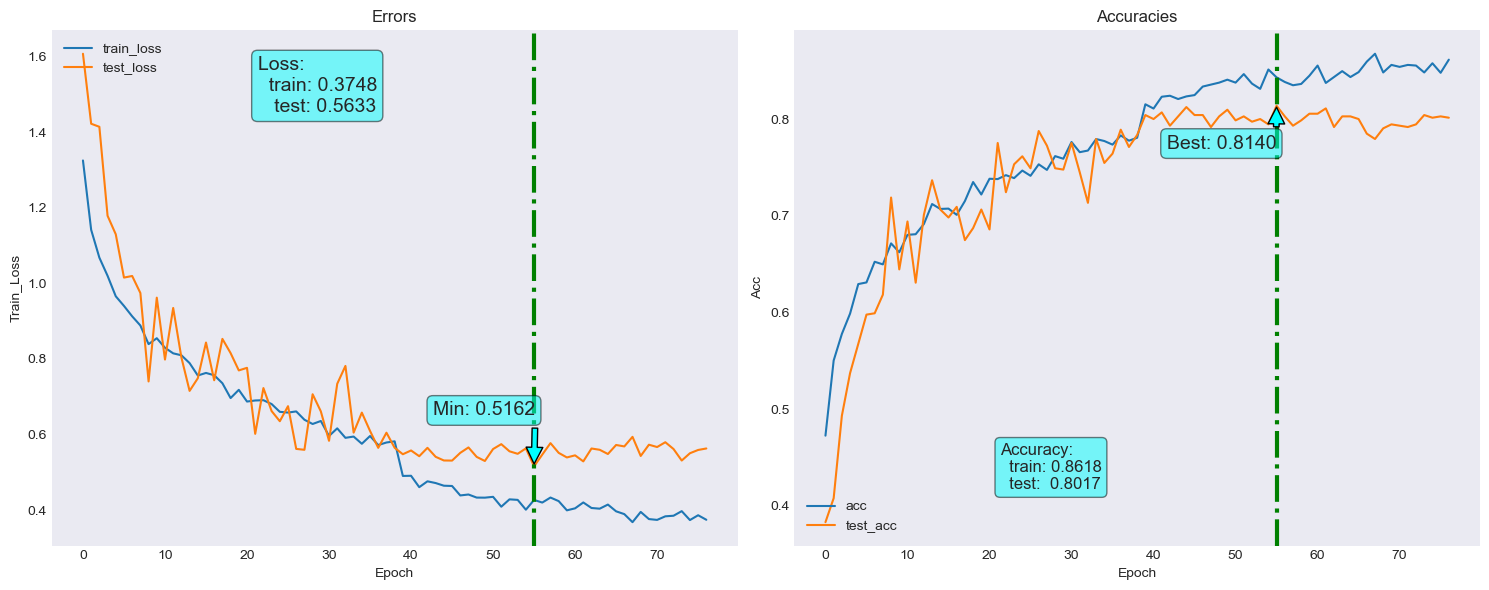

In [33]:
fn_plot_torch_hist(loss_df)